In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict
from coffea import hist

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.12/04


In [2]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [3]:
import matplotlib as mpl
mpl.style.use('seaborn-bright')

In [4]:
web_dir = '/publicweb/m/mreid/iDM_AN_Plots/MetTriggerStudy'

# Define functions

In [5]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

In [20]:
import scipy.special
from scipy.optimize import curve_fit, fsolve
from scipy import odr

def fsigmoid(z, p0, p1):
    return 1.0 / (1.0 + np.exp(-p0*(z-p1)))
def ferf_cf(z, p0, p1, p2, p3):
    return p2 + p3*scipy.special.erf((z-p0)/p1)
def f98percentile_cf(z, p):
    return ferf_cf(z, *p) - (p[2]+p[3])*0.98
def ferf_odr(p, z):
    return p[2] + p[3]*scipy.special.erf((z-p[0])/p[1])
def f98percentile_odr(z, p):
    return ferf_odr(p, z) - (p[2]+p[3])*0.98

def make_plot(ax, sample, objs, variable, plot_props, event_selection='df'):
    h0 = ROOT.TH1F(f'h0_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    h1 = ROOT.TH1F(f'h1_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    for l,x in objs[event_selection].query('fired0==True')[variable].iteritems():
        h0.Fill(x)
    for l,x in objs[event_selection].query('fired0==True & fired==True')[variable].iteritems():
        h1.Fill(x)
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
    ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'], 
                label=f'{props["label"]}', markersize=3, alpha=0.3, fmt='o', c=objs['color'])
    
    selection_string = 'pre-selected events' if event_selection == 'df' else 'all events'
    ax.set_title(f'Trigger efficiency as a function of MET (over {selection_string})')
    ax.set_xlabel('MET pT [GeV]')
    ax.set_ylabel('Trigger efficiency')
    ax.set_ylim((0,1))
    
    return data

def make_plot_fit_cf(ax, sample, objs, variable, plot_props, event_selection='df'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    popt, pcov = curve_fit(ferf_cf, data['x'][minbin:maxbin], data['y'][minbin:maxbin], sigma=data['yerr'][1][minbin:maxbin],
                           bounds=([50,0,-10,-10],[250,100,10,10]))
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {pcov[i,i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_cf, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_cf(fit_range, *popt), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    ax.legend()
    
def make_plot_fit_odr(ax, sample, objs, variable, plot_props, event_selection='df'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    
    model = odr.Model(ferf_odr)
    xerror = np.repeat(data['x'][1]-data['x'][0], len(data['x'])-minbin)
    real_data = odr.RealData(data['x'][minbin:maxbin], data['y'][minbin:maxbin], sx=xerror, sy=data['yerr'][0][minbin:maxbin])
    odr_obj = odr.ODR(real_data, model, beta0=[132, 36, 0.5, 0.5])
    out = odr_obj.run()
    
    popt = out.beta
    perr = out.sd_beta
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {perr[i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_odr, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_odr(popt, fit_range), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    
    ax.legend()

# Load data

In [13]:
redirector = 'root://cmseos.fnal.gov/'
basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv2'
samples = {
    '5p25': {
        'filename': redirector + basedir + '/Mchi-5p25_dMchi-0p5_ctau-100/MetTrigStudyv2_Mchi-5p25_dMchi-0p5_ctau-100.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.1$',
        'color': 'C0'
    },
    '52p5': {
        'filename': redirector + basedir + '/Mchi-52p5_dMchi-5p0_ctau-100/MetTrigStudyv2_Mchi-52p5_dMchi-5p0_ctau-100.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.1$',
        'color': 'C1'
    },
    '6p0': {
        'filename': redirector + basedir + '/Mchi-6p0_dMchi-2p0_ctau-100/MetTrigStudy_Mchi-6p0_dMchi-2p0_ctau-100.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.4$',
        'color': 'C2'
    },
    '60p0': {
        'filename': redirector + basedir + '/Mchi-60p0_dMchi-20p0_ctau-100/MetTrigStudyv2_Mchi-60p0_dMchi-20p0_ctau-100.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.4$',
        'color': 'C3'
    },
}

In [28]:
for sample, objs in samples.items():
    file = uproot.open(objs['filename'])
    #objs['trig_tree'] = file['TRIG_dsa_HLT_PFMET120_PFMHT120/trigEffiForMuTrack']
    #objs['selftrig_tree'] = file['TRIGself_dsa_HLT_PFMET120_PFMHT120/trigSelfEffiForMuTrack']
    #objs['df'] = objs['trig_tree'].pandas.df()
    #objs['self_df'] = objs['selftrig_tree'].pandas.df()
    objs['trig_tree'] = file['RECO_dsa/MetTrigSelfEffiForMuTrack']
    objs['df'] = objs['trig_tree'].pandas.df()
    #print(objs['df'])
    #objs['enrich'] = objs[(objs['recoJetEta'] > 100) & (objs['recoJetEta']<4.5)]
#objs['df']

In [26]:
#_dict = {}
#for sample, props in samples.items():
#    _counts = props['df'].groupby('entry').nth(0)['fired'].value_counts()
#    print(_counts)
#    _dict[sample] = {}
#    _dict[sample]['num_total'] = props['self_df'].groupby('entry').nth(0)['fired'].value_counts().sum()
#    print(_dict[sample]['num_total'])
#    _dict[sample]['num_select'] = _counts.sum()
#    _dict[sample]['num_trig'] = _counts.iloc[0]
#    _dict[sample]['trig_over_total'] = _counts.iloc[0] / _dict[sample]['num_total']
#    _dict[sample]['trig_over_select'] = _counts.iloc[0] / _counts.sum()
#    
#pd.options.display.float_format = '{:,.2f}'.format
#df = pd.DataFrame(_dict)
#cols = ['num_total', 'num_select', 'num_trig', 'trig_over_total', 'trig_over_select']
#df = df.transpose()[cols].transpose()
#df.to_csv(web_dir + '/trigger_cutflow.csv')
#df

# Comparison of triggered vs pre-selected distributions with Coffea

# Comparison of triggered vs pre-selected distributions without Coffea

In [15]:
eff_plots = OrderedDict({
    'pt': {
        'axis': np.array(np.append(np.arange(5,22,3), [30]), dtype='float64'),
        'range': [0, 30],
        'label': 'Leading muon pT [GeV]'
    },
    'eta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading muon eta'
    },
    'phi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading muon phi'
    },
    'recoJetPt': {
        'axis': np.array(np.arange(30,300,30), dtype='float64'),
        'range': [0, 500],
        'label': 'Leading jet pT [GeV]'
    },
    'recoJetEta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading jet eta'
    },
    'recoJetPhi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading jet phi'
    },
    'recoPFMetPt': {
        'axis': np.array(np.arange(30,300,30), dtype='float64'),
        'range': [0, 500],
        'label': 'MET pT [GeV]'
    },
})
#     'recoPFMetPhi': {
#         'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
#         'label': 'MET phi'
#     },

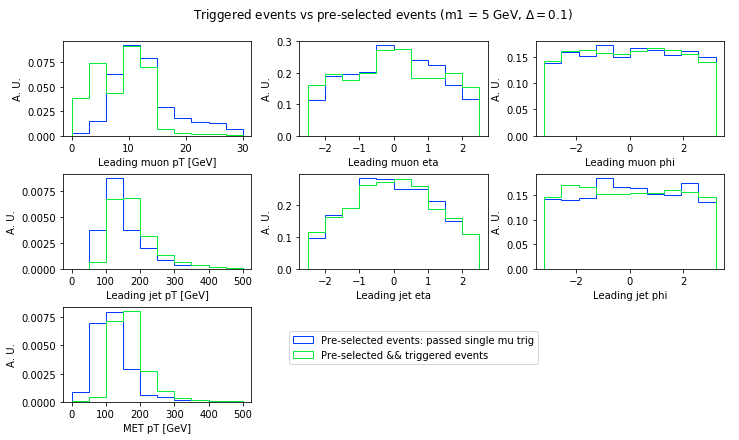

In [19]:
sample = '5p25'

fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle(f'Triggered events vs pre-selected events ({samples[sample]["label"]})')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, props) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = props['axis']
    kwargs = {'range': props['range'], 'bins':10, 'density': True, 'histtype':'step'}
    
    df = samples[sample]['df']
    ax.hist(df.query('fired0==True')[column].groupby('entry').nth(0), **kwargs, 
            label='Pre-selected events: passed single mu trig');
    ax.hist(df.query('fired==True & fired==True')[column].groupby('entry').nth(0), **kwargs, 
            label='Pre-selected && triggered events');
    ax.set_xlabel(props['label'])
    ax.set_ylabel('A. U.')

ax.legend(loc=(1.2 ,0.4))
#fig.savefig(f'{web_dir}/Trig_vs_preselected_{sample}.png', bbox_inches='tight')

# Trigger efficiency of `MET_120` vs kinematic variables -- pre-selected events

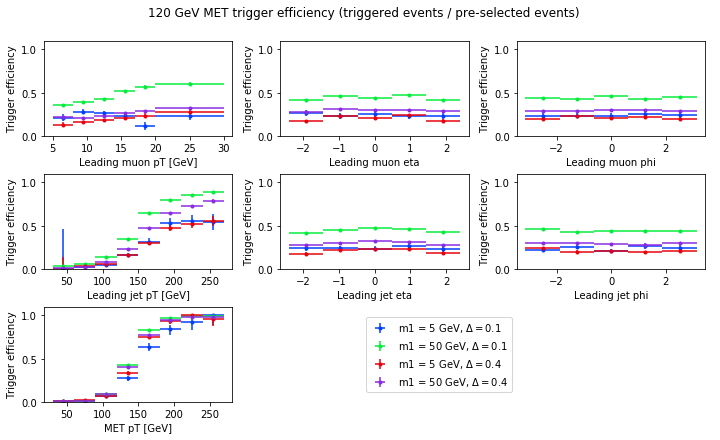

In [23]:
fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle('120 GeV MET trigger efficiency (triggered events / pre-selected events)')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, properties) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = properties['axis']
    
    for sample, objs in samples.items():
    
        if 'h0' in locals():
            del h0,h1
    
        h0 = ROOT.TH1F(f'h0_1', '', len(bin_edges)-1, bin_edges)
        h1 = ROOT.TH1F(f'h1_1', '', len(bin_edges)-1, bin_edges)

        for l,x in objs['df'].query('fired0==True')[column].groupby('entry').nth(0).iteritems():
            h0.Fill(x)
        for l,x in objs['df'].query('fired0==True & fired==True')[column].groupby('entry').nth(0).iteritems():
            h1.Fill(x)

        eff = ROOT.TEfficiency(h1, h0)
        data = extract_teffi(eff)
    
        if column == 'pt':
            xerr=np.diff(bin_edges)/2
        else:
            xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)

        ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'],
                    fmt='o', label=f'{objs["label"]}', ms=3, c=objs['color'])
        ax.set_xlabel(properties['label'])
        ax.set_ylabel('Trigger efficiency')
        ax.set_ylim(0,1.1)
        
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(-0.8,0.1));

#fig.savefig(f'{web_dir}/trigger_eff_preselected.png', bbox_inches='tight')

[m1 = 5 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
152.12 +- 4.29
41.76 +- 8.26
0.47 +- 0.00
0.46 +- 0.00

[m1 = 50 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
139.64 +- 0.17
36.60 +- 0.47
0.50 +- 0.00
0.49 +- 0.00



/cvmfs/sft.cern.ch/lcg/views/LCG_92python3/x86_64-slc6-gcc62-opt/lib/python3.6/site-packages/scipy/optimize/minpack.py:666: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / asarray(sigma) if sigma is not None else None


ValueError: Residuals are not finite in the initial point.

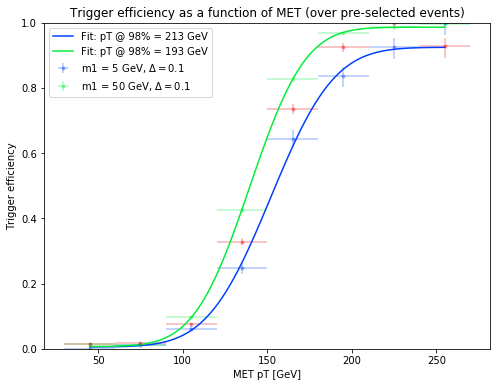

In [24]:
# Using cf (curve_fit), no x or y errors in the fit

fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    make_plot_fit_cf(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='df')

#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected.png', bbox_inches='tight')

/cvmfs/sft.cern.ch/lcg/views/LCG_92python3/x86_64-slc6-gcc62-opt/lib/python3.6/site-packages/scipy/odr/odrpack.py:394: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)


[m1 = 5 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
132.00 +- 0.00
36.00 +- 0.00
0.50 +- 0.00
0.50 +- 0.00

[m1 = 50 GeV, $\Delta = 0.1$]
fit parameter 1-sigma error
———————————–
143.66 +- 6.01
31.29 +- 5.83
0.50 +- 0.00
0.49 +- 0.00

[m1 = 5 GeV, $\Delta = 0.4$]
fit parameter 1-sigma error
———————————–
150.45 +- 1.65
41.35 +- 1.58
0.51 +- 0.00
0.50 +- 0.00

[m1 = 50 GeV, $\Delta = 0.4$]
fit parameter 1-sigma error
———————————–
144.69 +- 1.53
39.49 +- 1.44
0.50 +- 0.00
0.49 +- 0.00



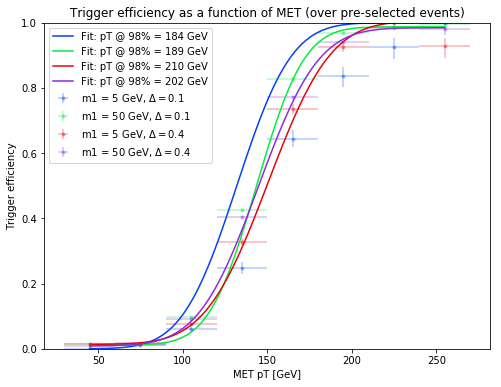

In [25]:
# Using ODR, includes both x errors (bin width) and y errors

fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    make_plot_fit_odr(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='df')

#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected.png', bbox_inches='tight')

# Trigger efficiency of `MET_120`  vs kinematic distributions -- all events